# Post Calibration
1. Assess Results
    - Recalculate results for training set using best coefficients
    - Use best coefficients to calculate objective function for the test set
    - Compare against the shortest path results (with and without the elevation correction) using both training and testing sets
1. Look at where calibrated function did the best/worst job for both the training/testing set
1. Cluster/segment results based on loss function value?
4. Export for application in BikewaySim

In [114]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from stochopy.optimize import minimize
import stochastic_optimization
from tqdm import tqdm
import similaritymeasures
import random
import matplotlib.pyplot as plt

from shapely.ops import LineString, MultiLineString

import sys
sys.path.insert(0,str(Path.cwd().parent))
from network.src import modeling_turns
import speedfactor

In [115]:
import json
config = json.load((Path.cwd().parent / 'config.json').open('rb'))
calibration_fp = Path(config['project_directory']) / 'Calibration'
cycleatl_fp = Path(config['project_directory']) / 'CycleAtlanta'
matching_fp = Path(config['project_directory']) / 'Map_Matching'
network_fp = Path(config['project_directory']) / 'Network'
if calibration_fp.exists() == False:
    calibration_fp.mkdir()

# Import Calibration Results and Calibration Network

In [116]:
with (calibration_fp/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
with (calibration_fp/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)

In [117]:
#dicts for referencing certain link attributes quickly
length_dict = dict(zip(links['linkid'],links['length_ft'])) # need this for loss function
geo_dict = dict(zip(links['linkid'],links['geometry']))

In [118]:
with (calibration_fp/'test_set.pkl').open('rb') as fh:
    test_set = pickle.load(fh)
with (calibration_fp/'train_set.pkl').open('rb') as fh:
    train_set = pickle.load(fh)

# import random
# random_trip = 1797#random.choice(list(train_set.keys()))
# train_set = {random_trip:train_set[random_trip]}

#match the ods to the network
train_ods = stochastic_optimization.match_results_to_ods(train_set)
test_ods = stochastic_optimization.match_results_to_ods(test_set)

In [119]:

'''
Currently works with binary and numeric variables. Categorical data will have to be
cast into a different format for now.

Link impedance is weighted by the length of the link, turns are just the impedance associated
'''

#customize this function to change impedance formula
#TODO streamline process of trying out new impedance functions
def link_impedance_function(betas,beta_links,links,base_impedance_col):
    #prevent mutating the original links gdf
    links = links.copy()
    
    multiplier = np.zeros(links.shape[0])
    
    if len(beta_links) > 0:
        #assumes that these effects are additive
        #TODO i think this can be done as a matrix product
        for key, item in beta_links.items():
            multiplier = multiplier + (betas[key] * links[item].values)
    
        links['link_cost'] = links[base_impedance_col] * (1 + multiplier) #removeing the + 1 for now

    else:
        links['link_cost'] = links[base_impedance_col]

    return links

def turn_impedance_function(betas,beta_turns,turns):
    #use beta coefficient to calculate turn cost
    # base_turn_cost = 30 # from Lowry et al 2016 DOI: http://dx.doi.org/10.1016/j.tra.2016.02.003
    # turn_costs = {
    #     'left': betas[1] * base_turn_cost,
    #     'right': betas[1] * base_turn_cost,
    #     'straight': betas[1] * base_turn_cost
    # }
    #turns['turn_cost'] = turns['turn_type'].map(turn_costs)

    turns = turns.copy()
    turns['turn_cost'] = 0

    if len(beta_turns) > 0:
        #instance impedance
        for key, item in beta_turns.items():
            turns['turn_cost'] = turns['turn_cost'] + (betas[key] * turns[item])

    #not sure if needed
    turns['turn_cost'] = turns['turn_cost'].astype(float)

    return turns

# Shortest Path Comparison

In [120]:
loss_function = stochastic_optimization.jaccard_index
loss_function_kwargs = {'length_dict':length_dict}
base_impedance_col = "travel_time_min"

In [121]:
#shortest path results here for comparison
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}
loss_shortest_train = loss_function(train_set,results_dict,**loss_function_kwargs)
print(loss_shortest_train.mean().round(5))
# 0.29911

0.29911


(array([163.,  91.,  68.,  39.,  27.,  25.,  15.,  14.,  21.,  37.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

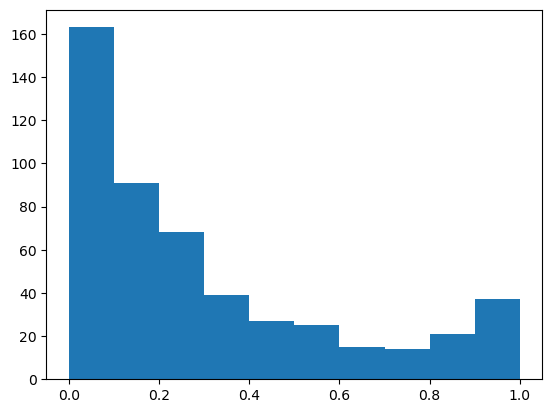

In [122]:
plt.hist(loss_shortest_train)

In [123]:
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}
loss_shortest_test = loss_function(test_set,results_dict,**loss_function_kwargs)
print(loss_shortest_test.mean().round(5))
# 0.3053

0.3053


(array([161.,  92.,  53.,  41.,  43.,  21.,  18.,  20.,  20.,  31.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

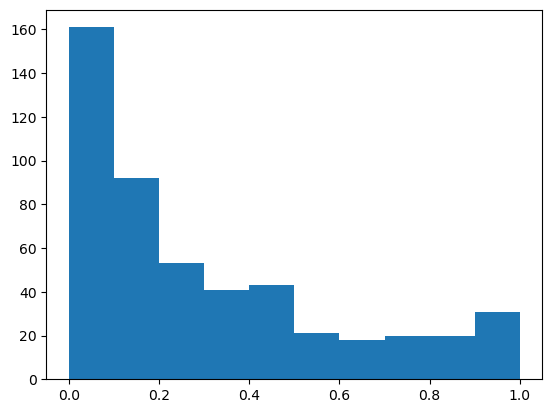

In [124]:
plt.hist(loss_shortest_test)

In [125]:
# #shortest path results here for comparison
# stochastic_optimization.back_to_base_impedance("adj_travel_time_min",links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}
# loss_values = loss_function(train_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.31022

In [126]:
# stochastic_optimization.back_to_base_impedance("adj_travel_time_min",links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}
# loss_values = loss_function(test_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.30337

# Generate Shortest Paths from Calibrated Coefficients

In [127]:
calibration_results

[{'high_traffic_stress': 0.0661610119497198,
  'left': 2.363333949708205,
  'right': 2.875007430851495,
  'signalized': 1.0893697547325298,
  'loss': -0.31058206517829084},
 {'class_1': 0.2308230358521835,
  'class_2': 1.2595525736224469,
  'class_3': 1.6777012261955218,
  'high_traffic_stress': 1.3901822221263547,
  'loss': -0.058962721570665844},
 {'major_road_w_class_2': 0.009352298764821576,
  'minor_road_w_class_2': 0.7192848670201979,
  'major_road_no_facil': 1.0242846535338108,
  'minor_road_no_facil': 1.4280555289480468,
  'above_4': 1.5152250035581623,
  'unsig_major_road_crossing': 0.012773275662048,
  'loss': -0.2903367458779148,
  'beta_links': {0: 'major_road_w_class_2',
   1: 'minor_road_w_class_2',
   2: 'major_road_no_facil',
   3: 'minor_road_no_facil',
   4: 'above_4'},
  'beta_turns': {5: 'unsig_major_road_crossing'}},
 {'mixed_traffic_no_facil': 0.46263003513032264,
  'mixed_traffic_w_facil': 0.12362448102583937,
  'above_4': 1.5311721170426633,
  'unsig_major_road_

In [133]:
calibration_result = calibration_results[-1]
calibration_result


{'mixed_traffic_no_facil': 0.46263003513032264,
 'mixed_traffic_w_facil': 0.12362448102583937,
 'above_4': 1.5311721170426633,
 'unsig_major_road_crossing': 1.3426500745160708,
 'loss': -0.31513428304183927,
 'beta_links': {0: 'mixed_traffic_no_facil',
  1: 'mixed_traffic_w_facil',
  2: 'above_4'},
 'beta_turns': {3: 'unsig_major_road_crossing'}}

In [138]:
betas = list(calibration_result.values())[0:-3]
betas_links = calibration_result['beta_links']
betas_turns = calibration_result['beta_turns']
# betas_links = {
#     0 : 'major_road_w_class_2',
#     1 : 'minor_road_w_class_2',
#     2 : 'major_road_no_facil',
#     3 : 'minor_road_no_facil',
# }
# betas_turns = {
#     4 : 'unsig_major_road_crossing'
# }
betas

[0.46263003513032264,
 0.12362448102583937,
 1.5311721170426633,
 1.3426500745160708]

In [139]:
#link_impedance_col = "adj_travel_time_min"
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          link_impedance_function,
                          base_impedance_col,
                          turn_impedance_function,
                          links,turns,turn_G)

#find shortest path
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}

#calulate objective function
loss_train = loss_function(train_set,results_dict,**loss_function_kwargs)
loss_train.mean()

[0.46263003513032264, 0.12362448102583937, 1.5311721170426633, 1.3426500745160708]


0.31513428304183927

(array([168.,  90.,  55.,  50.,  30.,  24.,  20.,  16.,  16.,  31.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

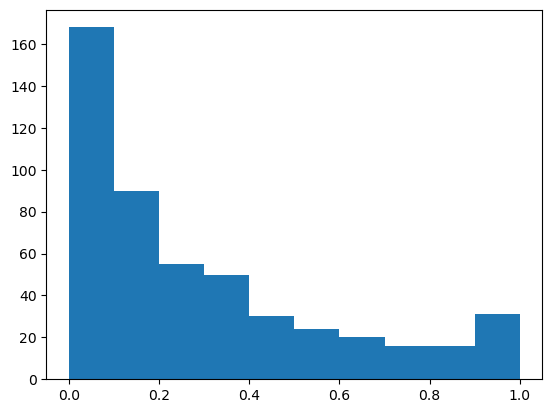

In [59]:
import matplotlib.pyplot as plt
plt.hist(loss_train)

In [140]:
#link_impedance_col = "adj_travel_time_min"
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          link_impedance_function,
                          base_impedance_col,
                          turn_impedance_function,
                          links,turns,turn_G)

#find shortest path
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}

#calulate objective function
loss_test = loss_function(test_set,results_dict,**loss_function_kwargs)
loss_test.mean()

[0.46263003513032264, 0.12362448102583937, 1.5311721170426633, 1.3426500745160708]


0.3317244178557114

In [150]:
#make dataframe and export
testing = pd.DataFrame({'shortest':loss_shortest_test,'impedance':loss_test})
testing.to_csv(calibration_fp/'testing_results.csv',index=False)
training = pd.DataFrame({'shortest':loss_shortest_train,'impedance':loss_train})
training.to_csv(calibration_fp/'training_results.csv',index=False)

(array([133.,  64.,  68.,  63.,  51.,  30.,  27.,  16.,  19.,  29.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

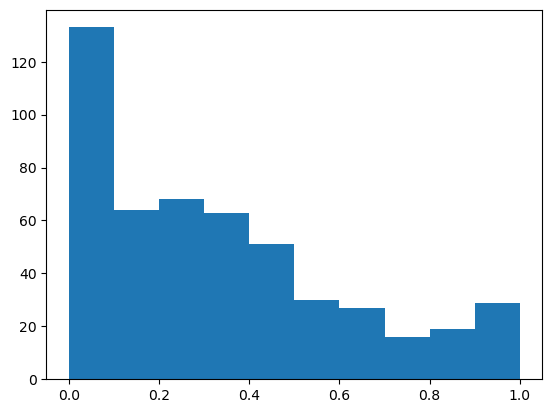

In [141]:
import matplotlib.pyplot as plt
plt.hist(loss_test)

# Distribution of Loss Function

# Export to get route attributes

# Using BRouter Results
To compare across we'll use Frechet distance. Will need to use next time.

In [90]:
with (calibration_fp/'brouter_links.txt').open('r') as file:
    my_list = file.readlines()
    # Remove any extra whitespace or newline characters
    my_list = [line.strip() for line in my_list]
len(my_list)

991

In [91]:
geojsons = list((calibration_fp/'GeoJSON_Out').glob('*.geojson'))

In [75]:
both_ods = list(set.union(set(train_ods),set(test_ods)))
len(both_ods)

989

In [77]:
len(geojsons)

991

In [113]:
#use the results dict combined with the geo dict one
results_dict[(68166811, 8789832117)]
#

{'length': 23.4,
 'edge_list': [(1125760528, False),
  (1125760532, False),
  (1125760521, True),
  (1125760514, True),
  (1125760444, True),
  (1125760439, True),
  (1125760449, True),
  (1125760450, True),
  (1125760436, True),
  (1125760429, True),
  (1125760291, True),
  (1125760274, True),
  (1125760278, True),
  (1125760294, True),
  (1125760296, True),
  (1125760300, True),
  (1125760301, True),
  (1125760303, True),
  (1125760305, True),
  (1125760307, True),
  (1125761489, True),
  (1125761486, True),
  (1125761483, True),
  (1125761480, True),
  (1125761476, True),
  (1125761471, True),
  (1125760798, True),
  (1125760790, True),
  (1125760785, True),
  (1125760777, True),
  (1125760776, True),
  (1125761359, True),
  (1125760131, True),
  (1125761305, True),
  (1125760130, True),
  (1125760148, True),
  (1125760768, True),
  (1125760757, True),
  (1125760749, True),
  (1125760739, True),
  (1125760149, True),
  (1125760151, True),
  (1125759954, True),
  (1125766052, True),


In [111]:
geojson_geos = []
for geojson in geojsons:
    geojson_geo = gpd.read_file(geojson).to_crs(config['projected_crs_epsg'])
    geojson_geo = np.array(geojson_geo.geometry.item().coords)
    # geojson_geo = [(x, y) for x, y, z in geojson_geo.coords]
    # geojson_geo = LineString(geojson_geo)
    geojson_geos.append(geojson_geo)

In [ ]:
frechet_distance = similaritymeasures.frechet_dist(chosen_coords,modeled_coords)

In [108]:
#import and compare frechet distance across them with geodict?
list(geojson_geo.coords)

[(2235730.589335955, 1366548.8726989387),
 (2235722.0962178116, 1366557.6220891697),
 (2235712.9846300976, 1366560.9146435678),
 (2235423.044373836, 1366566.9382367416),
 (2235405.417044448, 1366567.336576209),
 (2235410.009065115, 1366739.8017288041),
 (2235414.265835654, 1366896.2572918013),
 (2235414.919899986, 1366919.907531587),
 (2235415.5796504775, 1366946.4687167078),
 (2235421.779350321, 1367164.050580961),
 (2235424.72507782, 1367271.7502139185),
 (2235431.61495892, 1367531.5396371153),
 (2235433.5934286844, 1367610.8593477465),
 (2235437.101697713, 1367851.0064598424),
 (2235437.801214831, 1367897.9442805026),
 (2235440.7077528015, 1367985.631192954),
 (2235442.400983305, 1368230.1483304019),
 (2235442.1276262277, 1368245.7952633654),
 (2235443.0948035032, 1368274.1752122461),
 (2235471.358913126, 1368274.1199729599),
 (2235519.682842508, 1368274.7533273527),
 (2235908.0892177173, 1368275.452887525),
 (2235914.7753504696, 1368275.4399170876),
 (2236145.4462260376, 1368274.62